In [3]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'Deep_learning_kursus/assignments/assignment1/' such 
#that e.g.:  FOLDERNAME = 'Deep_learningE22/assignments/assignment1/'

FOLDERNAME = None
FOLDERNAME = 'Deep_learningE22/assignments/'

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Multiclass Support Vector Machine exercise

*Complete this exercise and enclude results and output graphs along with desribtions of the model and development method in the assignment submission. 

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'


# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Data Loading and Preprocessing

In [58]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del HAM_train_data
   del HAM_val_data
   del HAM_test_data
   print('Clear previously loaded data.')
except:
   pass


# Load the training and tuning datasets.
%cd /content/drive/My\ Drive/$FOLDERNAME/datasets/HAM_modified/
HAM_train_data = np.load('HAM_train.npz',allow_pickle=True)
HAM_val_data = np.load('HAM_val.npz',allow_pickle=True)
HAM_test_data = np.load('HAM_test.npz',allow_pickle=True)
%cd /content/drive/My\ Drive/$FOLDERNAME

#load and print header to view some info on the data and example data
header = HAM_train_data['header']
print('\n')
print(header)
print('\n')
print(HAM_train_data['images'][0].shape,HAM_train_data['meta'][0][:],'label: ',HAM_train_data['labels'][0])
print('\n')
X_train, y_train, train_meta = HAM_train_data['images'], HAM_train_data['labels'], HAM_train_data['meta']

X_val, y_val, val_meta = HAM_val_data['images'], HAM_val_data['labels'], HAM_val_data['meta']

X_test, y_test, test_meta = HAM_test_data['images'], HAM_test_data['labels'], HAM_test_data['meta']

#labels are of type np.float32 but need to be converted into uint 8 for use for slicing later
y_train = np.array([int(i) for i in y_train])
y_val = np.array([int(i) for i in y_val])
y_test = np.array([int(i) for i in y_test])

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Training meta info shape: ', train_meta.shape)
print('\n')
print('Val data shape: ', X_val.shape)
print('Val labels shape: ', y_val.shape)
print('Val meta info shape: ', val_meta.shape)
print('\n')
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Test meta info shape: ', test_meta.shape)

Clear previously loaded data.
/content/drive/My Drive/Deep_learningE22/assignments/datasets/HAM_modified
/content/drive/My Drive/Deep_learningE22/assignments


['image_array' 'image_id' 'dx' 'dx_type' 'age' 'sex' 'localization']


(48, 48, 3) ['ISIC_0028005' 'nv' 'follow_up' '45.0' 'male' 'trunk'] label:  2.0


Training data shape:  (13932, 48, 48, 3)
Training labels shape:  (13932,)
Training meta info shape:  (13932, 6)


Val data shape:  (2821, 48, 48, 3)
Val labels shape:  (2821,)
Val meta info shape:  (2821, 6)


Test data shape:  (2866, 48, 48, 3)
Test labels shape:  (2866,)
Test meta info shape:  (2866, 6)


Number of classes = 3


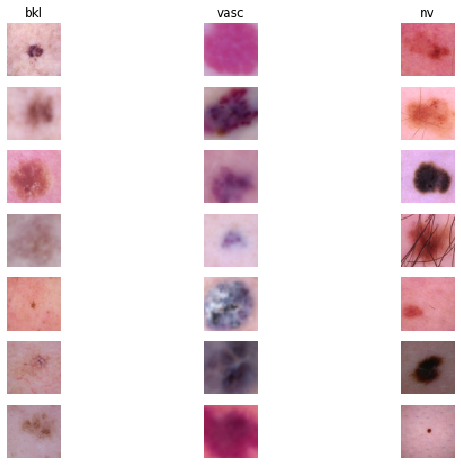

In [59]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
# we are going to be classifying three different types of 
# skin lesion on images sampled and modified from the HAM10000 data-set:
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T 


class_dict = {'bkl':'benign keratosis-like lesions', 
               'vasc':'vascular lesions', 
               'nv':'melanocytic nevi'}


num_classes = len(class_dict.keys())

print('Number of classes = {}'.format(num_classes))

samples_per_class = 7
for y, cls in enumerate(class_dict.keys()):
    idxs = np.where(train_meta[:] == cls)[0]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [60]:
# The data is alreade split the into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.

num_dev = 500

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(X_train.shape[0], num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]


print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Dev data shape: ', X_dev.shape)
print('Dev labels shape: ', y_dev.shape)

Train data shape:  (13932, 48, 48, 3)
Train labels shape:  (13932,)
Validation data shape:  (2821, 48, 48, 3)
Validation labels shape:  (2821,)
Test data shape:  (2866, 48, 48, 3)
Test labels shape:  (2866,)
Dev data shape:  (500, 48, 48, 3)
Dev labels shape:  (500,)


In [61]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (13932, 6912)
Validation data shape:  (2821, 6912)
Test data shape:  (2866, 6912)
dev data shape:  (500, 6912)


[192.56496 144.48407 155.54823 193.51831 145.14003 156.4786  194.35071
 145.6503  157.23729 195.01694]


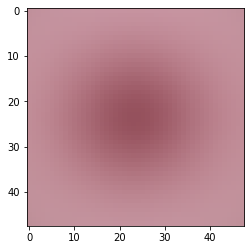

(13932, 6913) (2821, 6913) (2866, 6913) (500, 6913)


In [62]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((48,48,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [10]:
# Evaluate the naive implementation of the loss we provided for you:
from classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix- of small numbers
W = np.random.randn(6913, 3) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 1.944469


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [11]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
#from deep_learningE22.gradient_check import grad_check_sparse
from classifiers.Deep_learning_course.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 0.107870 analytic: 0.107870, relative error: 1.277771e-10
numerical: -2.163658 analytic: -2.163658, relative error: 2.831414e-13
numerical: 5.172910 analytic: 5.172910, relative error: 7.944982e-12
numerical: -0.923528 analytic: -0.923528, relative error: 2.458947e-12
numerical: 5.061817 analytic: 5.061817, relative error: 3.746206e-12
numerical: 13.985283 analytic: 13.985283, relative error: 1.105326e-11
numerical: -4.886744 analytic: -4.886744, relative error: 1.592680e-11
numerical: 9.663041 analytic: 9.663041, relative error: 7.170565e-12
numerical: 5.241056 analytic: 5.241056, relative error: 4.850358e-12
numerical: -8.453270 analytic: -8.453270, relative error: 4.369408e-12
numerical: 6.162445 analytic: 6.162445, relative error: 1.467363e-12
numerical: -11.092922 analytic: -11.092922, relative error: 3.629683e-12
numerical: -1.818062 analytic: -1.818062, relative error: 3.129489e-11
numerical: 0.674584 analytic: 0.674584, relative error: 1.010089e-10
numerical: -12.717

**Inline Question**

Consider the following. Include qustion and answers in your report if you think it adds value.

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*


In [12]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 1.944469e+00 computed in 0.033865s
Vectorized loss: 1.944469e+00 computed in 0.016245s
difference: 0.000000


In [13]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))
print('Naive gradient: '.format(grad_naive))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))
print('Vectorized gradient: '.format(grad_vectorized))


# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.036794s
Naive gradient: 
Vectorized loss and gradient: computed in 0.015908s
Vectorized gradient: 
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `classifiers/linear_classifier.py`.

In [14]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 520.216282
iteration 100 / 1500: loss 190.736240
iteration 200 / 1500: loss 70.568746
iteration 300 / 1500: loss 26.345764
iteration 400 / 1500: loss 10.175880
iteration 500 / 1500: loss 4.400707
iteration 600 / 1500: loss 2.298085
iteration 700 / 1500: loss 1.278598
iteration 800 / 1500: loss 1.032407
iteration 900 / 1500: loss 1.041564
iteration 1000 / 1500: loss 0.953869
iteration 1100 / 1500: loss 0.913040
iteration 1200 / 1500: loss 0.968547
iteration 1300 / 1500: loss 0.966423
iteration 1400 / 1500: loss 1.117588
That took 11.106780s


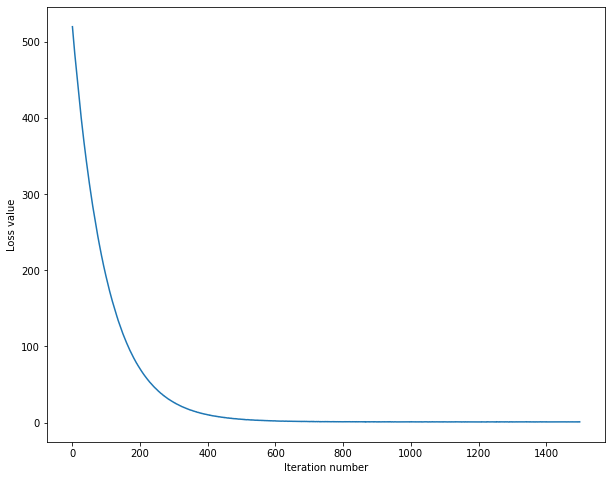

In [15]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [25]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.768303
validation accuracy: 0.766749


In [69]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for i in range(128):
    learning_rate = np.power(10, np.random.uniform(-6.6, -6.1))
    reg = np.power(10, np.random.uniform(4.0, 4.7))
    svm = LinearSVM()
    
    loss_hist = svm.train(X_train, y_train, learning_rate=learning_rate,
                          reg=reg, num_iters=300,
                          batch_size=200, verbose=False)
    
    y_train_pred = svm.predict(X_train)
    train_accuracy = np.mean(y_train_pred == y_train)
    y_val_pred   = svm.predict(X_val)
    val_accuracy   = np.mean(y_val_pred == y_val)
    
    if best_val < val_accuracy:
        best_svm, best_val = svm, val_accuracy
        
    results[(learning_rate, reg)] = (train_accuracy, val_accuracy)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.564090e-07 reg 2.513469e+04 train accuracy: 0.765073 val accuracy: 0.767104
lr 2.604704e-07 reg 2.083499e+04 train accuracy: 0.765504 val accuracy: 0.751861
lr 2.607943e-07 reg 1.278675e+04 train accuracy: 0.769739 val accuracy: 0.750798
lr 2.622607e-07 reg 4.349211e+04 train accuracy: 0.746698 val accuracy: 0.735555
lr 2.647313e-07 reg 4.943516e+04 train accuracy: 0.725452 val accuracy: 0.719957
lr 2.654091e-07 reg 4.158913e+04 train accuracy: 0.752943 val accuracy: 0.759305
lr 2.654631e-07 reg 1.773221e+04 train accuracy: 0.766939 val accuracy: 0.732719
lr 2.671642e-07 reg 2.395523e+04 train accuracy: 0.760982 val accuracy: 0.769940
lr 2.695958e-07 reg 2.655910e+04 train accuracy: 0.759331 val accuracy: 0.765331
lr 2.772431e-07 reg 1.726711e+04 train accuracy: 0.774404 val accuracy: 0.765686
lr 2.839578e-07 reg 2.080060e+04 train accuracy: 0.761125 val accuracy: 0.758596
lr 2.874645e-07 reg 4.249838e+04 train accuracy: 0.744330 val accuracy: 0.747962
lr 2.944688e-07 reg 2.866219

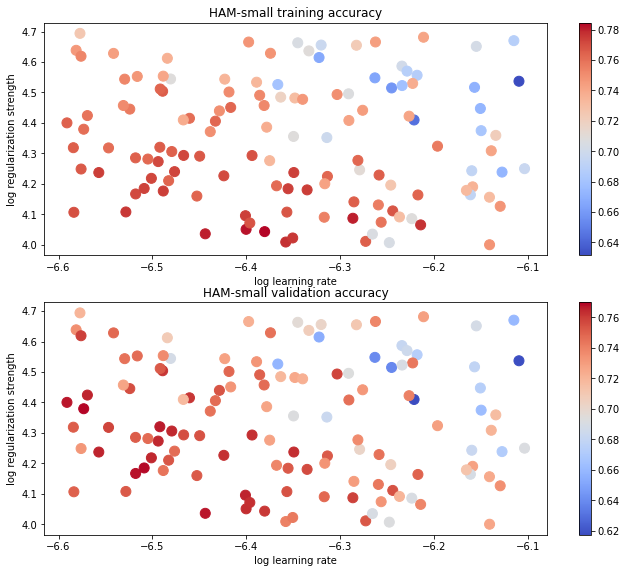

In [70]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('HAM-small training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('HAM-small validation accuracy')
plt.show()

In [71]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.766574


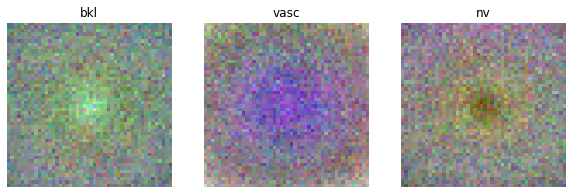

In [72]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(48, 48, 3, 3)
w_min, w_max = np.min(w), np.max(w)
classes = ['bkl', 'vasc','nv']
for i in range(3):
    plt.subplot(1, 3, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question**

In the report, describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.


